In [169]:
import glob
import json
import cv2
import re
import sys
import time

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from gc import collect
from time import sleep

from gensim.models import KeyedVectors

%matplotlib inline

In [57]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *

In [2]:
SYMBOL_FILTER = re.compile('\W')

In [3]:
w2v = KeyedVectors.load_word2vec_format("./word_embeddings/gensim_w2v.model")

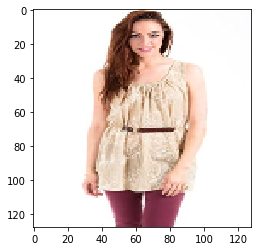

In [4]:
image = cv2.cvtColor(
    cv2.resize(
        cv2.imread("./data/images/B00BZ8GPVO .jpg"),
        (128,128)
    ),
    cv2.COLOR_BGR2RGB
)

plt.imshow(image)

In [5]:
json_files = glob.glob("./data/captions/*train.json")
raw_captions = []
for file in json_files:
#     *_,cloth_type ,_,_=  file.split('.')
    with open(file,"r") as file:
        raw_captions += json.load(file)

['is black and without collar', 'is black and more revealing']


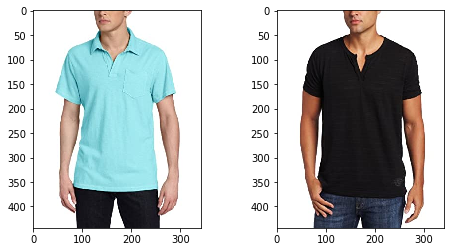

In [6]:
cap = raw_captions[4]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(cv2.cvtColor(cv2.imread(f'./data/images/{cap["candidate"]} .jpg'),cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(cv2.imread(f'./data/images/{cap["target"]} .jpg'),cv2.COLOR_BGR2RGB))

print (cap['captions'])

In [7]:
%%time

captions = []
targets = []
candidates = []

pairs = []

def read_image(name):
    return cv2.resize(
        cv2.cvtColor(
            cv2.imread(f"./data/images/{name} .jpg"),
            cv2.COLOR_BGR2RGB
        ),
        (128,128)
    )

def vectorize(caption):
    tokens = caption.lower().split(" ")
    return np.array([ list(w2v[word]) for word in tokens] + ( [np.zeros(64)]*(24-len(tokens)) )).astype(np.float32)

lag = 0

for i,cap in enumerate(raw_captions):
    if not i%1000:
        collect()
    try:
        candidates.append(read_image(cap['candidate']))
    except:
        lag += 1
        continue
        
    try:
        targets.append(read_image(cap['target']))
    except:
        _ = candidates.pop()
        lag += 1
        continue
    
    i -= lag
    for j,c in enumerate(cap['captions']):
        captions.append(vectorize(SYMBOL_FILTER.sub(' ',c)))
        pairs.append([ i,i+j,i ])
    
captions = np.array(captions)
targets = np.array(targets)
candidates = np.array(candidates)

pairs = np.array(pairs)

CPU times: user 2min 6s, sys: 3min, total: 5min 6s
Wall time: 2min 34s


In [8]:
captions.shape[0],targets.shape[0],candidates.shape[0],pairs.shape[0]

(35990, 17995, 17995, 35990)

In [379]:
### Query Encoder

initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
def dense(x,units,activation="tanh"):
    x = Dense(units,use_bias=False,kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)    
    return x

def conv_block(x,filters,kernel_size=3,strides=1,activation='tanh'):    
    x = Conv2D(filters,1,use_bias=False,strides=strides,padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = DepthwiseConv2D(kernel_size,padding='same',kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x
    
# Caption Encoder
cap_in = Input((24,64))

cap_l1 = LSTM(units=128,return_sequences=True,kernel_initializer=initializer)(cap_in)
cap_dr1 = Dropout(0.35)(cap_l1)
cap_td1 = TimeDistributed(Dense(64,kernel_initializer=initializer))(cap_dr1)

cap_l2 = LSTM(units=64,return_sequences=True,kernel_initializer=initializer)(cap_td1)
cap_dr2 = Dropout(0.35)(cap_l2)
cap_td2 = TimeDistributed(Dense(32,kernel_initializer=initializer))(cap_dr2)
cap_gap = GlobalAveragePooling1D()(cap_td2)

# Image Encoder

img_in = Input(shape=(128,128,3))

img_b1 = conv_block(img_in,32,kernel_size=3,strides=2)
img_b2 = conv_block(img_b1,32,kernel_size=3,strides=1)

img_b3 = conv_block(img_b2,64,kernel_size=3,strides=2)
img_b4 = conv_block(img_b3,64,kernel_size=3,strides=1)
img_b5 = conv_block(img_b4,64,kernel_size=3,strides=1)

img_b6 = conv_block(img_b5,128,kernel_size=3,strides=2)
img_b7 = conv_block(img_b6,128,kernel_size=3,strides=1)
img_b8 = conv_block(img_b7,128,kernel_size=3,strides=1)
img_b9 = conv_block(img_b8,128,kernel_size=3,strides=1)

img_b10 = conv_block(img_b9,256,kernel_size=3,strides=2)
img_b11 = conv_block(img_b10,256,kernel_size=3,strides=1)
img_b12 = conv_block(img_b11,256,kernel_size=3,strides=1)
img_b13 = conv_block(img_b12,256,kernel_size=3,strides=1)
img_b14 = conv_block(img_b13,256,kernel_size=3,strides=1)

img_gap = GlobalAveragePooling2D()(img_b14)
img_d1 = dense(img_gap,64)
img_d2 = dense(img_d1,32)

qr_enc = Average()([cap_gap,img_d2])
qr_d1 = dense(qr_enc,1024)
qr_d2 = dense(qr_enc,256)
qr_out = dense(qr_enc,8,'tanh') 
    
img_enc = dense(img_gap,1024,)
img_enc = dense(img_enc,256,)
img_out = dense(img_enc,8,'tanh') 

image_encoder = keras.Model(img_in,img_out)
query_encoder = keras.Model([cap_in,img_in],qr_out)

In [380]:
image_encoder((targets[0:1].astype(np.float32) - 127.5)/127.5)

<tf.Tensor: id=900300, shape=(1, 8), dtype=float32, numpy=
array([[ 0.01590864, -0.00516221,  0.01272257, -0.0003541 , -0.00319954,
         0.00020656,  0.0009065 , -0.00170947]], dtype=float32)>

In [381]:
l2 = keras.losses.MeanAbsoluteError()
opt1 = opt = keras.optimizers.RMSprop(9e-6)
opt2 = opt = keras.optimizers.RMSprop(9e-6)

@tf.function
def step(d,c,t):
    """
    d : candidate
    c : caption
    t : target
    """
    with tf.GradientTape() as tape1,tf.GradientTape() as tape2:
        encoded_query = query_encoder((c,d))
        encoded_target = image_encoder(t)
        
        loss = l2(encoded_target,encoded_query)
        
    grads1 = tape1.gradient(loss, query_encoder.trainable_variables)
    opt1.apply_gradients(zip(grads1, query_encoder.trainable_variables))
    
    grads2 = tape2.gradient(loss, image_encoder.trainable_variables)
    opt2.apply_gradients(zip(grads2, image_encoder.trainable_variables))
    
    return loss

In [382]:
def yield_pairs(batch_size):
    br = len(pairs)%batch_size
    
    while True:
        index = np.arange(0,len(pairs))
        np.random.shuffle(index)
        _p = pairs[index][:-br]
        p_ = pairs[index][-br:]
        for batch in _p.reshape(-1,batch_size,3):
            yield (
                ( ( candidates[batch[:,0]] - 127.5 ) / 127.5 ).astype(np.float32),
                ( captions[batch[:,1]]  ).astype(np.float32),
                ( ( targets[batch[:,2]] - 127.5 ) / 127.5 ).astype(np.float32)
            )
        yield ( 
            ( ( candidates[p_[:,0]] - 127.5 ) / 127.5 ).astype(np.float32),
            ( captions[p_[:,1]] ).astype(np.float32),
            ( ( targets[p_[:,2]] - 127.5 ) / 127.5 ).astype(np.float32) 
        ) 

In [383]:
batch_size = 16
epochs = 1
steps_per_epoch = len(pairs)// batch_size

gen = yield_pairs(batch_size=batch_size)

In [367]:
bar_length = 25
bar_step = steps_per_epoch // bar_length

for epoch in range(epochs):
    start = time.time()
    for i in range(steps_per_epoch):
        loss = step(*next(gen))
        progress = i // bar_step
        sys.stdout.write(f'\rEpoch : {epoch} [ {"-"*(progress)} { " "*(bar_length-progress)}] {i}/{steps_per_epoch} | loss : {loss.numpy():0.6f} | {int(time.time()-start)}')
        sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()

Epoch : 0 [ ------------------------- ] 2248/2249 | loss : 0.205831 | 855


In [384]:
def image_flow(images,batch_size):
    br = len(images)%batch_size
    while True:
        index = np.arange(0,len(images))
        np.random.shuffle(index)
        _p = index[:-br]
        p_ = index[-br:]
        for batch in _p.reshape(-1,batch_size):
            yield (images[batch] - 127.5 ).astype(np.float32) / 127.5
        yield (images[p_] - 127.5 ).astype(np.float32) / 127.5

In [385]:
f_targets = image_flow(targets,32)
target_repr = image_encoder.predict(f_targets,steps=1 + (len(targets)//32),verbose=1)

563/563 [==============================] - 17s 31ms/step


In [386]:
target_repr

array([[ 1.98621657e-02, -6.99388469e-03,  1.46172587e-02, ...,
         2.89250864e-04, -3.50236334e-03,  9.79153672e-04],
       [ 1.65638197e-02, -5.45350043e-03,  1.22522162e-02, ...,
        -8.88368231e-05, -1.89442001e-03, -6.10898249e-04],
       [ 2.11379249e-02, -9.40138940e-03,  1.53543474e-02, ...,
        -3.98810866e-04, -3.46930028e-04,  3.85851687e-04],
       ...,
       [ 1.68252420e-02, -5.50575322e-03,  1.17930900e-02, ...,
         8.51969642e-04, -2.12729489e-03, -1.97872316e-04],
       [ 1.71335991e-02, -4.54289094e-03,  1.25197265e-02, ...,
        -1.14568463e-03, -1.56527793e-03, -2.08588061e-03],
       [ 1.81795005e-02, -3.54481209e-03,  1.14778662e-02, ...,
         1.55397272e-03, -6.20548055e-03, -1.09145313e-03]], dtype=float32)

In [344]:
def query_encode(text,image):
    image = ( image.reshape(1,128,128,3) - 127.5 ) / 127.5
    text = vectorize(text).reshape(1,24,64)
    return query_encoder.predict((text,image))

In [345]:
query_encode('is black with',img)

array([[0.78155065, 0.0187926 , 0.06832686, 0.204148  , 0.9665375 ,
        0.3269367 , 0.85704994, 0.24763644]], dtype=float32)

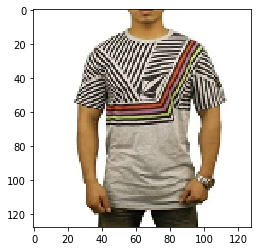

In [346]:
img = candidates[34].copy()
plt.imshow(img)

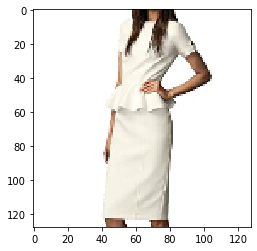

In [351]:
query = query_encode('is red with stripes',img)
targ = targets[np.square(target_repr - query).mean(axis=-1).argmax()]
plt.imshow(targ)